# Shot By Shot XGBoost Model

In [72]:
# Importing Relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Reading in data

In [73]:
shot_data = pd.read_csv('shot_dataset.csv')
shot_data = shot_data.drop(columns = ['Unnamed: 0'])

In [74]:
print(shot_data)

         SHOT_MADE  SHOT_TYPE  LOC_X  LOC_Y  SHOT_DISTANCE  MINS_LEFT  \
0                1          0   23.4  12.95             24         11   
1                1          1   -1.3   5.25              1         10   
2                0          1   -2.2   6.95              2          8   
3                1          0   19.7  20.55             24          7   
4                1          0   -8.3  29.85             25          7   
...            ...        ...    ...    ...            ...        ...   
2947516          1          1   -0.0   5.25              0         11   
2947517          1          1   -0.0   5.25              0         11   
2947518          1          1   -0.0   5.25              0         11   
2947519          1          1   14.3  11.35             15         11   
2947520          1          1   11.3   7.55             11         11   

         SECS_LEFT    MP    FG%    3P%  ...  Reverse Slam Dunk Shot  \
0               20  36.0  0.451  0.300  ...         

In [75]:
print(shot_data.columns)

Index(['SHOT_MADE', 'SHOT_TYPE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE',
       'MINS_LEFT', 'SECS_LEFT', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'Season',
       'DEF_RTG', 'Jump Shot', 'Running Finger Roll Layup Shot',
       'Driving Layup Shot', 'Pullup Jump shot',
       'Driving Finger Roll Layup Shot', 'Tip Layup Shot',
       'Step Back Jump shot', 'Driving Reverse Layup Shot',
       'Running Reverse Layup Shot', 'Layup Shot', 'Running Pull-Up Jump Shot',
       'Dunk Shot', 'Reverse Layup Shot', 'Running Dunk Shot',
       'Floating Jump shot', 'Driving Floating Jump Shot',
       'Cutting Layup Shot', 'Putback Layup Shot', 'Turnaround Jump Shot',
       'Turnaround Fadeaway shot', 'Running Jump Shot', 'Cutting Dunk Shot',
       'Turnaround Hook Shot', 'Running Layup Shot', 'Driving Dunk Shot',
       'Fadeaway Jump Shot', 'Cutting Finger Roll Layup Shot',
       'Running Alley Oop Layup Shot', 'Driving Floating Bank Jump Shot',
       'Running Alley Oop Dunk Shot', 'Driving Hook Shot

In [80]:
shot_data['Season'] = shot_data['Season'].astype(int)
print(type(shot_data['Season'][0]))

<class 'numpy.int64'>


In [81]:
print(shot_data['Season'].unique())

[2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008
 2007 2006 2005 2004]


In [82]:
# Naive Value
naive = 0.5442256065351188

## Subsetting data by year for training

In [83]:
data_4 = shot_data[shot_data['Season'] == 2004]
data_5 = shot_data[shot_data['Season'] == 2005]

## Only using one feature (distance)

In [84]:
dist_Xtrain = np.array(data_4['SHOT_DISTANCE']).reshape(-1,1)
dist_Ytrain = np.array(data_4['SHOT_MADE'])

dist_Xval = np.array(data_5['SHOT_DISTANCE']).reshape(-1,1)
dist_Yval = np.array(data_5['SHOT_MADE'])

## XGBoost with only distance feature

In [85]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

dist_xgboost = XGBClassifier()
xgboost_para = {'n_estimators': [100, 150, 300, 500],
                'max_leaves': np.arange(2,40),
                'learning_rate': [0.001,0.01, 0.1, 1]}


xgboost_search = RandomizedSearchCV(dist_xgboost, xgboost_para, scoring ='accuracy', random_state = 1, n_jobs = 4)
xgboost_search.fit(dist_Xtrain, dist_Ytrain)
print(xgboost_search.best_params_)
print(xgboost_search.best_score_)

{'n_estimators': 150, 'max_leaves': 4, 'learning_rate': 1}
0.6085606954569327


In [86]:
estterm = xgboost_search.best_params_['n_estimators']
leavesterm = xgboost_search.best_params_['max_leaves']
learningterm = xgboost_search.best_params_['learning_rate']


dist_xgboost = XGBClassifier(n_estimators = estterm, max_leaves = leavesterm, learning_rate = learningterm)
dist_xgboost.fit(dist_Xtrain, dist_Ytrain)
dist_xgboost_train = dist_xgboost.score(dist_Xtrain, dist_Ytrain)
dist_xgboost_val = dist_xgboost.score(dist_Xval, dist_Yval)

print(f'The training accuracy is {dist_xgboost_train}')
print(f'The validation accuracy is {dist_xgboost_val}')

The training accuracy is 0.6085607319465856
The validation accuracy is 0.6103514189089839


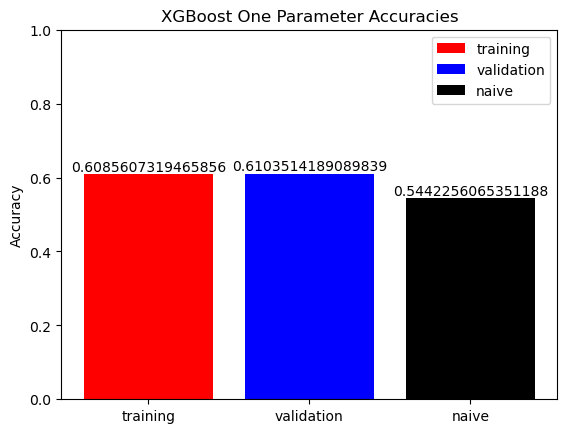

In [87]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [dist_xgboost_train, dist_xgboost_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('XGBoost One Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

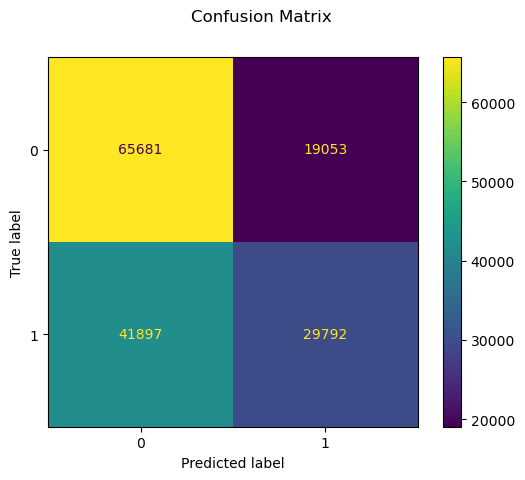

In [88]:
from sklearn import metrics
# Confusion matrix 
dist_xgboost_pred = dist_xgboost.predict(dist_Xval)
confusion_dist_xgboost = metrics.ConfusionMatrixDisplay.from_predictions(dist_Yval, dist_xgboost_pred, 
                                                                     values_format = '')
confusion_dist_xgboost.figure_.suptitle("Confusion Matrix")
plt.show()

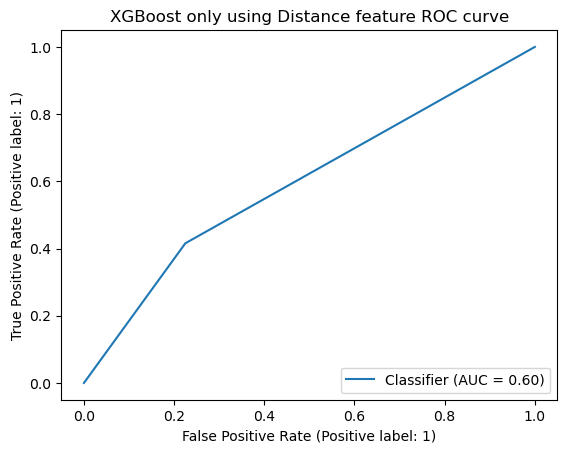

In [89]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay

# XGBoost
RocCurveDisplay.from_predictions(dist_Yval, dist_xgboost_pred)
plt.title('XGBoost only using Distance feature ROC curve')
plt.show()

## XGBoost using all features

In [90]:
Xtrain = np.array(data_4.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(data_4['SHOT_MADE'])

Xval = np.array(data_5.drop(columns = ['SHOT_MADE']))
Yval = np.array(data_5['SHOT_MADE'])

In [92]:
xgboost = XGBClassifier()

xgboost_search = RandomizedSearchCV(xgboost, xgboost_para, scoring = 'accuracy', random_state = 1, n_jobs = 4)
xgboost_search.fit(Xtrain, Ytrain)
print(xgboost_search.best_params_)
print(xgboost_search.best_score_)

{'n_estimators': 500, 'max_leaves': 10, 'learning_rate': 0.1}
0.6461857573145904


In [93]:
estterm = xgboost_search.best_params_['n_estimators']
leavesterm = xgboost_search.best_params_['max_leaves']
learningterm = xgboost_search.best_params_['learning_rate']

xgboost = XGBClassifier(n_estimators = estterm, max_leaves = leavesterm, learning_rate = learningterm)

xgboost.fit(Xtrain, Ytrain)
xgboost_train = xgboost.score(Xtrain, Ytrain)
xgboost_val = xgboost.score(Xval, Yval)
print(f'The training accuracy is {xgboost_train}')
print(f'The validation accuracy is {xgboost_val}')

The training accuracy is 0.651871575673854
The validation accuracy is 0.6392346394072483


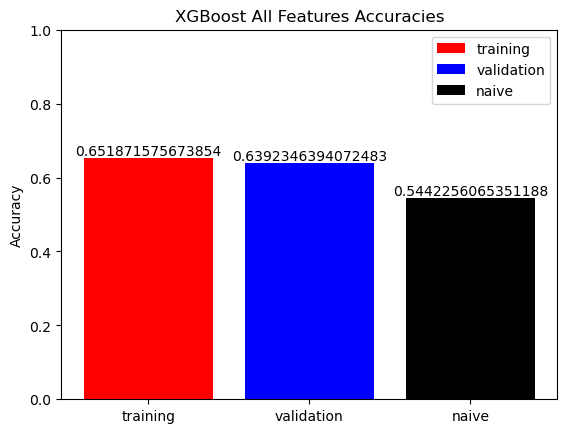

In [94]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [xgboost_train, xgboost_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue','black'])

ax.set_ylabel('Accuracy')
ax.set_title('XGBoost All Features Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

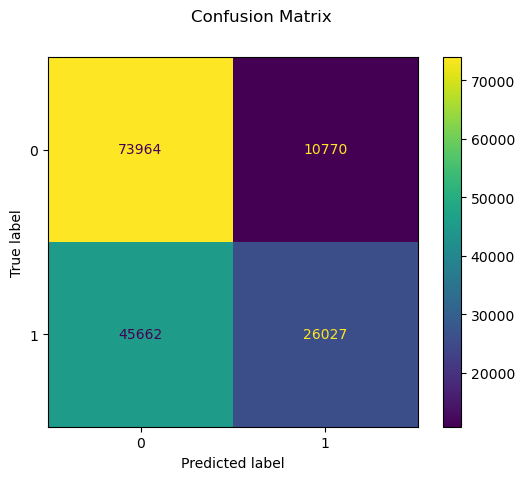

In [95]:
# Confusion matrix 
xgboost_pred = xgboost.predict(Xval)
confusion_xgboost = metrics.ConfusionMatrixDisplay.from_predictions(Yval, xgboost_pred, 
                                                                     values_format = '')
confusion_xgboost.figure_.suptitle("Confusion Matrix")
plt.show()

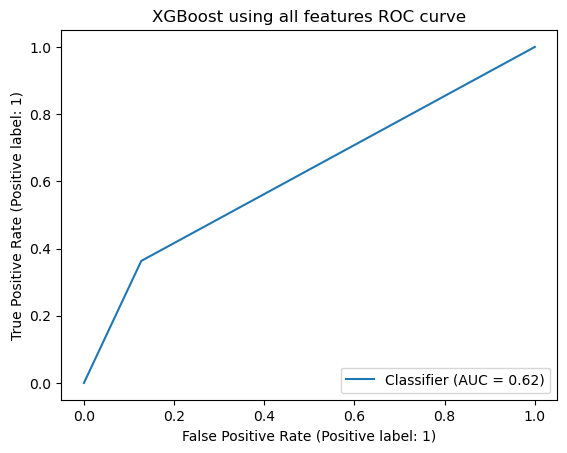

In [96]:
# XGBoost
RocCurveDisplay.from_predictions(Yval, xgboost_pred)
plt.title('XGBoost using all features ROC curve')
plt.show()

## Expanding the range of data 
#### TRAINING FROM 2004-2005
#### VALIDATION FROM 2006-2007

In [97]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2005)]
val_data = shot_data[(shot_data['Season'] >= 2006) & (shot_data['Season'] <= 2007)]

In [98]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xval = np.array(val_data.drop(columns = ['SHOT_MADE']))
Yval = np.array(val_data['SHOT_MADE'])

In [99]:
xgboost = XGBClassifier()

xgboost_search = RandomizedSearchCV(xgboost, xgboost_para, scoring = 'accuracy', random_state = 1, n_jobs = 4)
xgboost_search.fit(Xtrain, Ytrain)
print(xgboost_search.best_params_)
print(xgboost_search.best_score_)

{'n_estimators': 500, 'max_leaves': 10, 'learning_rate': 0.1}
0.6445358670454174


In [100]:
estterm = xgboost_search.best_params_['n_estimators']
leavesterm = xgboost_search.best_params_['max_leaves']
learningterm = xgboost_search.best_params_['learning_rate']

xgboost = XGBClassifier(n_estimators = estterm, max_leaves = leavesterm, learning_rate = learningterm)

xgboost.fit(Xtrain, Ytrain)
xgboost_train = xgboost.score(Xtrain, Ytrain)
xgboost_val = xgboost.score(Xval, Yval)
print(f'The training accuracy is {xgboost_train}')
print(f'The validation accuracy is {xgboost_val}')

The training accuracy is 0.6476703562216345
The validation accuracy is 0.6455353553691144


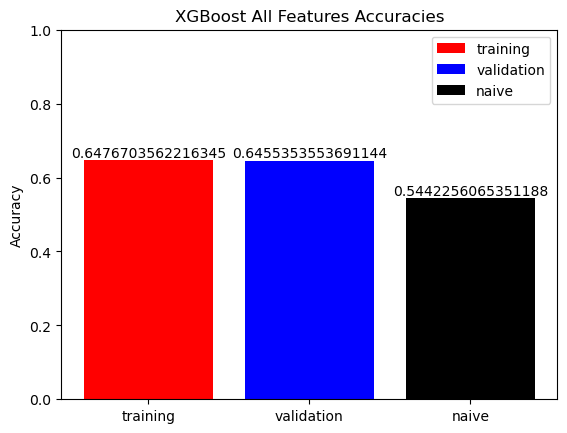

In [101]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [xgboost_train, xgboost_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue','black'])

ax.set_ylabel('Accuracy')
ax.set_title('XGBoost All Features Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

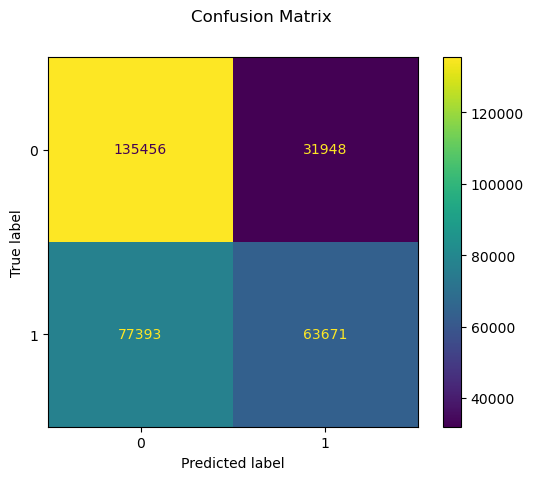

In [102]:
# Confusion matrix 
xgboost_pred = xgboost.predict(Xval)
confusion_xgboost = metrics.ConfusionMatrixDisplay.from_predictions(Yval, xgboost_pred, 
                                                                     values_format = '')
confusion_xgboost.figure_.suptitle("Confusion Matrix")
plt.show()

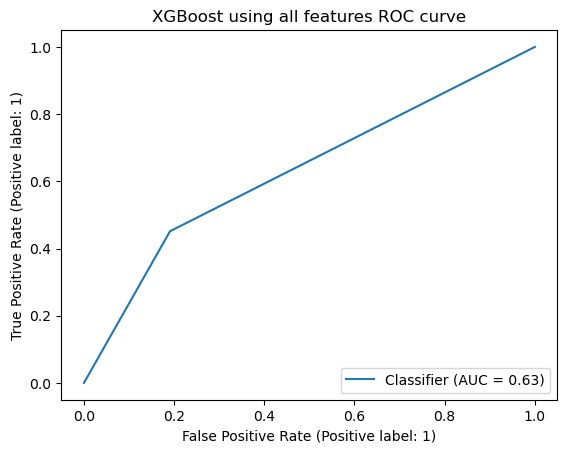

In [103]:
# XGBoost
RocCurveDisplay.from_predictions(Yval, xgboost_pred)
plt.title('XGBoost using all features ROC curve')
plt.show()

## Expanding the range of data 
#### TRAINING FROM 2004-2007
#### VALIDATION FROM 2008-2011

In [104]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2007)]
val_data = shot_data[(shot_data['Season'] >= 2008) & (shot_data['Season'] <= 2011)]

In [105]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xval = np.array(val_data.drop(columns = ['SHOT_MADE']))
Yval = np.array(val_data['SHOT_MADE'])

In [106]:
xgboost = XGBClassifier()

xgboost_search = RandomizedSearchCV(xgboost, xgboost_para, scoring = 'accuracy', random_state = 1, n_jobs = 4)
xgboost_search.fit(Xtrain, Ytrain)
print(xgboost_search.best_params_)
print(xgboost_search.best_score_)

{'n_estimators': 500, 'max_leaves': 10, 'learning_rate': 0.1}
0.6461354212714985


In [107]:
estterm = xgboost_search.best_params_['n_estimators']
leavesterm = xgboost_search.best_params_['max_leaves']
learningterm = xgboost_search.best_params_['learning_rate']

xgboost = XGBClassifier(n_estimators = estterm, max_leaves = leavesterm, learning_rate = learningterm)
xgboost.fit(Xtrain, Ytrain)
xgboost_train = xgboost.score(Xtrain, Ytrain)
xgboost_val = xgboost.score(Xval, Yval)
print(f'The training accuracy is {xgboost_train}')
print(f'The validation accuracy is {xgboost_val}')

The training accuracy is 0.6482794296106634
The validation accuracy is 0.6469894478535658


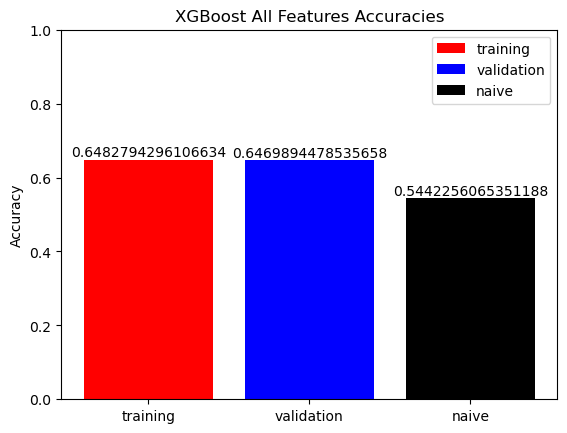

In [108]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [xgboost_train, xgboost_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue','black'])

ax.set_ylabel('Accuracy')
ax.set_title('XGBoost All Features Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

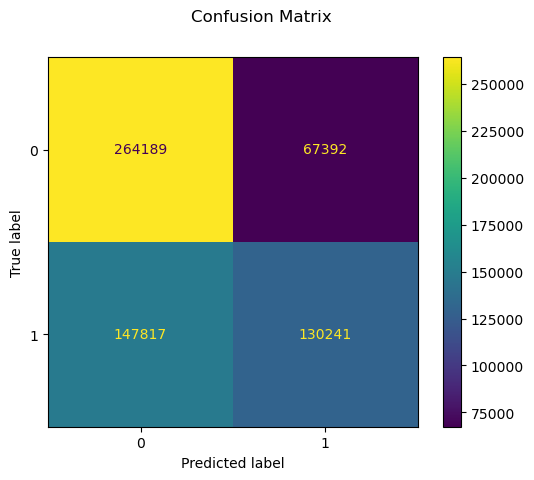

In [109]:
# Confusion matrix 
xgboost_pred = xgboost.predict(Xval)
confusion_xgboost = metrics.ConfusionMatrixDisplay.from_predictions(Yval, xgboost_pred, 
                                                                     values_format = '')
confusion_xgboost.figure_.suptitle("Confusion Matrix")
plt.show()

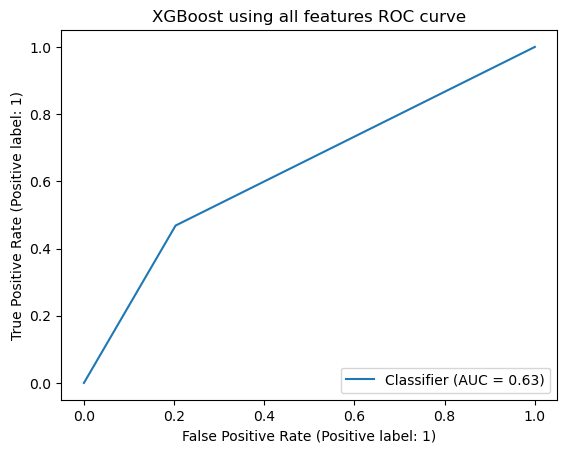

In [110]:
# XGBoost
RocCurveDisplay.from_predictions(Yval, xgboost_pred)
plt.title('XGBoost using all features ROC curve')
plt.show()

It seems that the model consistantly uses the parameters {'n_estimators': 500, 'max_leaves': 10, 'learning_rate': 0.1} so we will use this for the final testing

## Final Testing and Results

In [111]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2017)]
test_data = shot_data[(shot_data['Season'] >= 2018)]

In [112]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xtest = np.array(val_data.drop(columns = ['SHOT_MADE']))
Ytest = np.array(val_data['SHOT_MADE'])

In [113]:
xgboost = XGBClassifier(n_estimators = 500, max_leaves = 10, learning_rate = 0.1)
xgboost.fit(Xtrain, Ytrain)
xgboost_train = xgboost.score(Xtrain, Ytrain)
xgboost_test = xgboost.score(Xtest, Ytest)
print(f'The training accuracy is {xgboost_train}')
print(f'The testing accuracy is {xgboost_test}')

The training accuracy is 0.6487801581401635
The testing accuracy is 0.6527764791950647


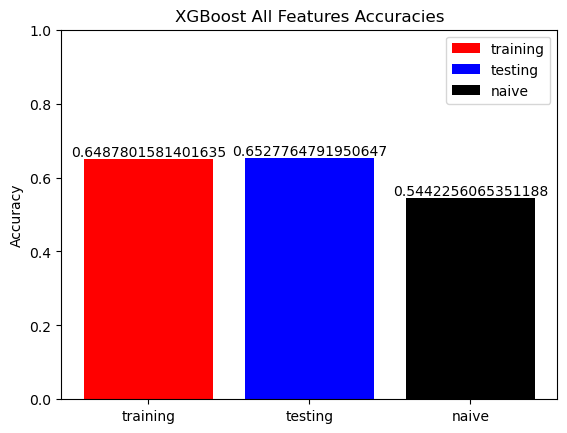

In [114]:
fig, ax = plt.subplots()

group = ['training', 'testing', 'naive']
counts = [xgboost_train, xgboost_test, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue','black'])

ax.set_ylabel('Accuracy')
ax.set_title('XGBoost All Features Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

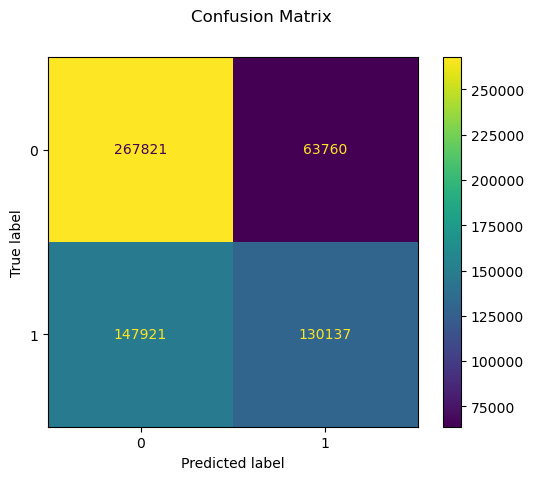

In [115]:
# Confusion matrix 
xgboost_pred = xgboost.predict(Xtest)
confusion_xgboost = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, xgboost_pred, 
                                                                     values_format = '')
confusion_xgboost.figure_.suptitle("Confusion Matrix")
plt.show()

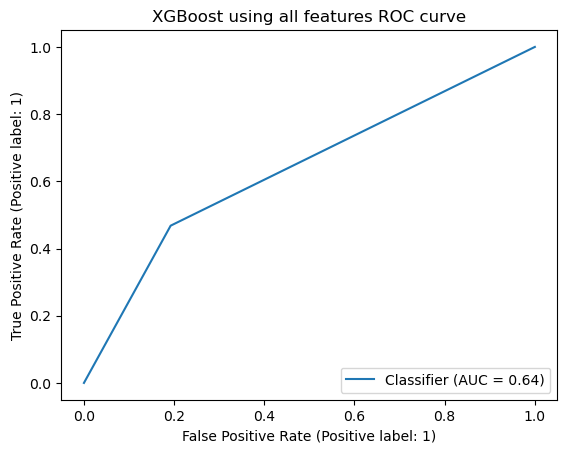

In [116]:
# XGBoost
RocCurveDisplay.from_predictions(Ytest, xgboost_pred)
plt.title('XGBoost using all features ROC curve')
plt.show()

In [117]:
important_features = pd.DataFrame(xgboost.feature_importances_.reshape(-1,1), 
                                  index = shot_data.drop(columns = ['SHOT_MADE']).columns, columns = ['Feature_Val'])
important_features = important_features.sort_values(by = ['Feature_Val'], ascending = False)

In [118]:
print(important_features.head(20))

                                Feature_Val
Driving Hook Shot                  0.358511
Putback Dunk Shot                  0.112816
Running Bank Hook Shot             0.055817
Turnaround Jump Shot               0.051399
Running Tip Shot                   0.044816
SHOT_DISTANCE                      0.038415
Running Slam Dunk Shot             0.033183
Jump Shot                          0.032492
Driving Reverse Layup Shot         0.022829
Driving Layup Shot                 0.022632
Floating Jump shot                 0.020039
Driving Reverse Dunk Shot          0.019096
Putback Layup Shot                 0.010082
Alley Oop Layup shot               0.009559
Tip Dunk Shot                      0.009087
Driving Finger Roll Layup Shot     0.007471
Step Back Bank Jump Shot           0.007379
Cutting Finger Roll Layup Shot     0.007339
MINS_LEFT                          0.007324
SECS_LEFT                          0.006367


In [119]:
top_20 = important_features.head(20)

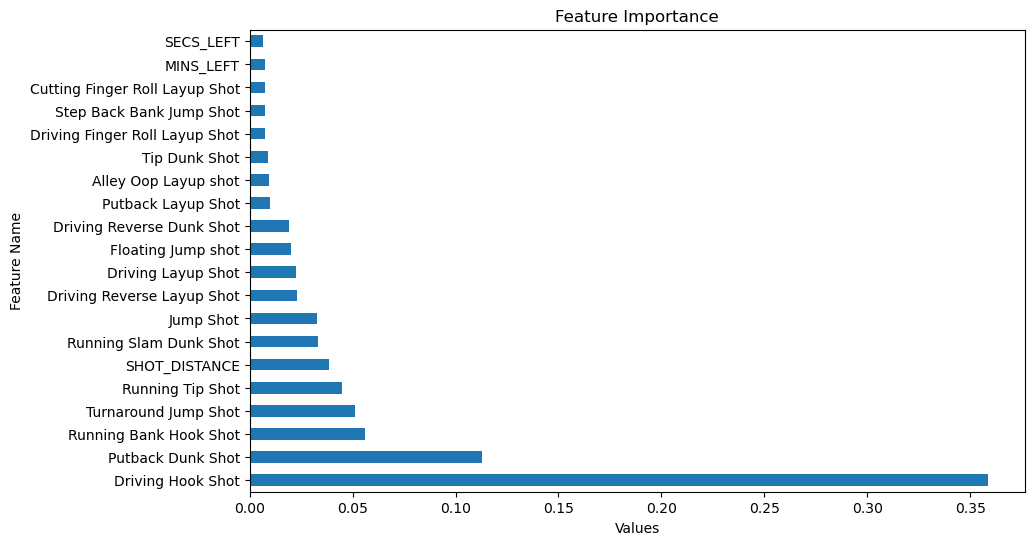

In [129]:
top_20['Feature_Val'].plot(kind='barh', figsize=(10, 6))

plt.xlabel('Values')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()